# Homework 2 - Test MWI

## Import Libraries

Import some libraries

In [6]:
%tensorflow_version 1.x

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 1.15.0
Found GPU at: /device:GPU:0


## Load data

In [7]:
import os
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
drive.mount('/content/drive')

trainingset = '/content/drive/My Drive/MWI-Dataset1/MWI-Dataset1'

batch_size = 64
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False,
    validation_split=0.2
    )


train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    trainingset, # same directory as training data
    target_size=(118, 224),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation') # set as validation data

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]
img_h=input_shape[0]
img_w=input_shape[1]
print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)
print('Loaded %d training samples from  %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(validation_generator.n,validation_generator.num_classes))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1604 images belonging to 4 classes.
Found 401 images belonging to 4 classes.
Image input (118, 224, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 1604 training samples from  4 classes.
Loaded 401 test samples from 4 classes.


## Model

### SvevaNet - MyCnn

Libraries for Net

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def SvevaNet(input_shape, num_classes):

    model = Sequential(name="SvevaNet")

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=15, input_shape=input_shape, kernel_size=(5,5)))
    model.add(Activation('relu'))

    # C2 Convolutional Layer
    model.add(Conv2D(filters=20, kernel_size=(5,5)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))

    # C3 Convolutional Layer
    model.add(Conv2D(filters=30, kernel_size=(3,3)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model.add(Flatten())


    # D1 Dense Layer
    model.add(Dense(128))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # D2 Dense Layer
    model.add(Dense(96))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    optimizer = optimizers.rmsprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model
 
# create the model
model = SvevaNet(input_shape,num_classes)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "SvevaNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 114, 220, 15)      1140      
_________________________________________________________________
activation_1 (Activation)    (None, 114, 220, 15)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 216, 20)      7520      
_________________________________________________________________
activation_2 (Activation)    (None, 110, 216, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 108, 20)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 106, 30)       5430      
__

Plot Model with layers and weights

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Pre-Trained Model - Transfer Learning

In [0]:
from keras import applications
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

# Create the base model from the pre-trained model
model_transfer = applications.ResNet101V2(weights = "imagenet", include_top=False, input_shape = input_shape)
print(len(model_transfer.layers))
not_trainable=len(model_transfer.layers)-1
for layer in model_transfer.layers[:not_trainable]:
  layer.trainable= False

#Adding custom Layers 
x = model_transfer.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(40, activation="relu")(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model_transfer.input, output = predictions, name="transferLearning")

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.09), metrics=["accuracy"])

377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="transferLearning", inputs=Tensor("in..., outputs=Tensor("de...)`


## Save the model

In [0]:
import os
models_dir = '/content/drive/My Drive/MWI-Dataset1/models'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'best_model')


Model saved successfully on file /content/drive/My Drive/MWI-Dataset1/models/best_model.h5



## Load a trained model

In [8]:
import os
from keras.models import load_model

models_dir = '/content/drive/My Drive/MWI-Dataset1/models'

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

model = loadmodel('best_model')


Model loaded successfully from file /content/drive/My Drive/MWI-Dataset1/models/best_model.h5



## Train

#### Train of SvevaNet 

In [0]:
from keras import callbacks

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=validation_generator.n//validation_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=100,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=validation_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/100
 3/25 [==>...........................] - ETA: 52s - loss: 1.6320 - acc: 0.3542

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


 4/25 [===>..........................] - ETA: 50s - loss: 1.5950 - acc: 0.3359

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


 5/25 [=====>........................] - ETA: 45s - loss: 1.5983 - acc: 0.3063

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


16/25 [==================>...........] - ETA: 15s - loss: 1.4264 - acc: 0.3330

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


25/25 [==============================] - 40s 2s/step - loss: 1.3713 - acc: 0.3470 - val_loss: 1.1723 - val_acc: 0.5511
Epoch 2/100
25/25 [==============================] - 40s 2s/step - loss: 1.1452 - acc: 0.5031 - val_loss: 1.0057 - val_acc: 0.5860
Epoch 3/100
25/25 [==============================] - 39s 2s/step - loss: 1.0152 - acc: 0.5666 - val_loss: 0.8386 - val_acc: 0.6708
Epoch 4/100
25/25 [==============================] - 40s 2s/step - loss: 0.9727 - acc: 0.5770 - val_loss: 0.8191 - val_acc: 0.6783
Epoch 5/100
25/25 [==============================] - 39s 2s/step - loss: 0.8912 - acc: 0.6207 - val_loss: 0.7633 - val_acc: 0.6509
Epoch 6/100
25/25 [==============================] - 41s 2s/step - loss: 0.8827 - acc: 0.6200 - val_loss: 0.7912 - val_acc: 0.6733
Epoch 7/100
25/25 [==============================] - 37s 1s/step - loss: 0.8698 - acc: 0.6106 - val_loss: 0.6996 - val_acc: 0.6858
Epoch 8/100
25/25 [==============================] - 40s 2s/step - loss: 0.8003 - acc: 0.6570 -

#### Train of pre-trained model

In [0]:
from keras import callbacks

stopping = callbacks.EarlyStopping(monitor='val_acc', patience=20)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = validation_generator.n//validation_generator.batch_size+1

try:
    history_transfer = model_final.fit_generator(train_generator, epochs=100, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=validation_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/100
 1/25 [>.............................] - ETA: 6:52 - loss: 1.6783 - acc: 0.2500

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 7/25 [=======>......................] - ETA: 53s - loss: 1.7299 - acc: 0.2857 

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


20/25 [=======================>......] - ETA: 9s - loss: 1.6538 - acc: 0.3391 

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


22/25 [=========================>....] - ETA: 5s - loss: 1.6424 - acc: 0.3452

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


25/25 [==============================] - 53s 2s/step - loss: 1.6366 - acc: 0.3484 - val_loss: 1.5442 - val_acc: 0.4065
Epoch 2/100
25/25 [==============================] - 43s 2s/step - loss: 1.3959 - acc: 0.4374 - val_loss: 1.2131 - val_acc: 0.5387
Epoch 3/100
25/25 [==============================] - 42s 2s/step - loss: 1.2309 - acc: 0.5048 - val_loss: 1.0908 - val_acc: 0.5711
Epoch 4/100
25/25 [==============================] - 43s 2s/step - loss: 1.1530 - acc: 0.5328 - val_loss: 0.9401 - val_acc: 0.6309
Epoch 5/100
25/25 [==============================] - 43s 2s/step - loss: 1.0425 - acc: 0.5832 - val_loss: 0.9561 - val_acc: 0.6259
Epoch 6/100
25/25 [==============================] - 42s 2s/step - loss: 0.9252 - acc: 0.6407 - val_loss: 0.9061 - val_acc: 0.6409
Epoch 7/100
25/25 [==============================] - 44s 2s/step - loss: 0.9501 - acc: 0.6231 - val_loss: 0.8870 - val_acc: 0.6633
Epoch 8/100
25/25 [==============================] - 42s 2s/step - loss: 0.9909 - acc: 0.6183 -

##Evaluate the model

### Accuracy on test set

##### SvevaNet

In [0]:
val_steps=validation_generator.n//validation_generator.batch_size+1
loss, acc = model.evaluate_generator(validation_generator,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)



##### Pre-Trained Model

In [0]:
val_steps=validation_generator.n//validation_generator.batch_size+1
loss, acc = model_final.evaluate_generator(validation_generator,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Test loss: 0.609994
Test accuracy: 0.760599


#### Precision, recall, F-score

##### SvevaNet

In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
 
preds = model.predict_generator(validation_generator,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


  

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


              precision    recall  f1-score   support

        HAZE      0.830     0.822     0.826       101
       RAINY      0.669     0.790     0.725       100
       SNOWY      0.705     0.550     0.618       100
       SUNNY      0.914     0.960     0.937       100

    accuracy                          0.781       401
   macro avg      0.780     0.780     0.776       401
weighted avg      0.780     0.781     0.776       401



##### Pre-Trained Model

In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
 
preds = model_final.predict_generator(validation_generator,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


              precision    recall  f1-score   support

        HAZE      0.780     0.842     0.810       101
       RAINY      0.800     0.720     0.758       100
       SNOWY      0.726     0.610     0.663       100
       SUNNY      0.805     0.950     0.872       100

    accuracy                          0.781       401
   macro avg      0.778     0.780     0.776       401
weighted avg      0.778     0.781     0.776       401



Confusion matrix analysis

In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict_generator(validation_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/validation_generator.n))
  

### Plot results

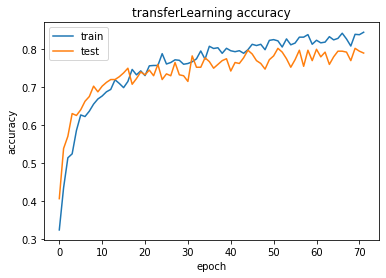

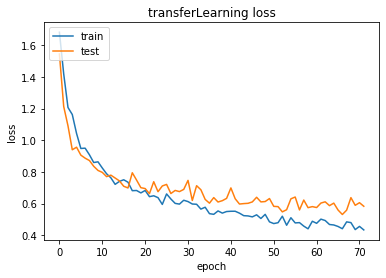

In [0]:
import matplotlib.pyplot as plt

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
        
#name="SvevaNet"
#plot_history(history, name)
name="transferLearning"
plot_history(history_transfer, name)

##Blind Test

In [4]:
blindtest= '/content/drive/My Drive/Blind/WeatherBlindTestSet'

blind_generator = train_datagen.flow_from_directory(
    directory=blindtest, # same directory as training data
    target_size=(118, 224),
    batch_size=batch_size,
    shuffle=False,
    class_mode=None) # set as validation data

Found 1500 images belonging to 1 classes.


In [9]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
preds = model.predict_generator(blind_generator)

Ypred = np.argmax(preds, axis=1)
print(Ypred)

[3 3 3 ... 3 3 0]


In [0]:
preds.argmax(-1)

array([3, 3, 3, ..., 3, 3, 0])

In [16]:
cH=0
cR=0
cSN=0
cSU=0
with open('/content/drive/My Drive/1743997.csv','w') as file:
    for i in range (0, len(Ypred)):
        if(Ypred[i]==0):
          cH= cH+1
          file.write("HAZE")
          file.write('\n')
        if(Ypred[i]==1):
          cR = cR +1
          file.write("RAINY")
          file.write('\n')
        if(Ypred[i]==2):
          cSN= cSN+1
          file.write("SNOWY")
          file.write('\n')
        if(Ypred[i]==3):
          cSU= cSU+1
          file.write("SUNNY")
          file.write('\n')
file.close()
print("haze ")
print(cH)
print("rainy ")
print(cR)
print("snowy ")
print(cSN)
print("sunny ")
print(cSU)

haze 
267
rainy 
457
snowy 
329
sunny 
447
